In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
games_data = pd.read_csv(
    "../../data/processed/cleaned_data_deliveries.csv",
    low_memory=False
)

In [3]:
games_data.drop(columns=["Unnamed: 0"],inplace=True)
games_data.tail()

match_id  inning batting_team bowling_team  over  ball   batter  \
260915   1426312       2          KKR          SRH     9     5  SS Iyer   
260916   1426312       2          KKR          SRH     9     6  VR Iyer   
260917   1426312       2          KKR          SRH    10     1  VR Iyer   
260918   1426312       2          KKR          SRH    10     2  SS Iyer   
260919   1426312       2          KKR          SRH    10     3  VR Iyer   

               bowler non_striker  batsman_runs  ...  toss_decision  winner  \
260915     AK Markram     VR Iyer             1  ...            bat     KKR   
260916     AK Markram     SS Iyer             1  ...            bat     KKR   
260917  Shahbaz Ahmed     SS Iyer             1  ...            bat     KKR   
260918  Shahbaz Ahmed     VR Iyer             1  ...            bat     KKR   
260919  Shahbaz Ahmed     SS Iyer             1  ...            bat     KKR   

         result  result_margin target_runs target_overs super_over     method  \
260915  wickets            8.0       114.0         20.0          N  No Issues   
260916  wickets            8.0       114.0         20.0          N  No Issues   
260917  wickets            8.0       114.0         20.0          N  No Issues   
260918  wickets            8.0       114.0         20.0          N  No Issues   
260919  wickets            8.0       114.0         20.0          N  No Issues   

              umpire1      umpire2  
260915  J Madanagopal  Nitin Menon  
260916  J Madanagopal  Nitin Menon  
260917  J Madanagopal  Nitin Menon  
260918  J Madanagopal  Nitin Menon  
260919  J Madanagopal  Nitin Menon  

[5 rows x 33 columns]

In [4]:
games_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260920 entries, 0 to 260919
Data columns (total 33 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   match_id          260920 non-null  int64  
 1   inning            260920 non-null  int64  
 2   batting_team      260920 non-null  object 
 3   bowling_team      260920 non-null  object 
 4   over              260920 non-null  int64  
 5   ball              260920 non-null  int64  
 6   batter            260920 non-null  object 
 7   bowler            260920 non-null  object 
 8   non_striker       260920 non-null  object 
 9   batsman_runs      260920 non-null  int64  
 10  extra_runs        260920 non-null  int64  
 11  total_runs        260920 non-null  int64  
 12  extras_type       14125 non-null   object 
 13  is_wicket         260920 non-null  int64  
 14  player_dismissed  12950 non-null   object 
 15  dismissal_kind    12950 non-null   object 
 16  fielder           93

# Batting Stats

In [5]:
# df = games_data[["batter","bowler","non_striker"]]
batter_unique = pd.Series(games_data["batter"].unique())
non_striker_unique = pd.Series(games_data["non_striker"].unique())
bowler_unique = pd.Series(games_data["bowler"].unique())
print(batter_unique.shape[0]+bowler_unique.shape[0]+non_striker_unique.shape[0])
players_list =pd.concat([batter_unique, non_striker_unique,bowler_unique])
print(players_list.shape)
players_list = players_list.unique()
print(players_list.shape)

1866
(1866,)
(732,)


In [6]:
def bowling_stats_generator(player,batting_stats):
    stats=[]
    try:
        bowler_grouped_data = games_data.groupby("bowler").get_group(player)
        #no of balls
        no_of_balls = bowler_grouped_data.shape[0] - bowler_grouped_data[(bowler_grouped_data["extras_type"]=="noballs") | (bowler_grouped_data["extras_type"]=="wides") ].shape[0]
        stats.append(no_of_balls)
        #no of overs
        no_of_overs = no_of_balls / 6
        stats.append(no_of_overs)
        #no of runs
        total_runs = bowler_grouped_data["batsman_runs"].sum() + bowler_grouped_data[(bowler_grouped_data["extras_type"]=="noballs") | (bowler_grouped_data["extras_type"]=="wides") ].shape[0]
        stats.append(total_runs)
        #economy
        economy = total_runs/no_of_overs
        stats.append(economy)
        #no of wickets
        no_of_wickets = bowler_grouped_data[bowler_grouped_data["dismissal_kind"].isna()==False].shape[0]
        stats.append(no_of_wickets)
        #bowling avg
        Bolwing_avg = total_runs/no_of_wickets
        stats.append(Bolwing_avg)
        #strike rate
        try:
            strike_rate = no_of_balls/no_of_wickets
            stats.append(strike_rate)
        except ZeroDivisionError:
            stats.append(np.nan)
        #bundary
        boundary_percentage = ((bowler_grouped_data[bowler_grouped_data["batsman_runs"]== 4].shape[0])+(bowler_grouped_data[bowler_grouped_data["batsman_runs"]== 6].shape[0]))/no_of_balls
        boundary_percentage = boundary_percentage * 100
        stats.append(boundary_percentage)
    except KeyError:
        stats = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
    final_stats= pd.concat([pd.Series(batting_stats),pd.Series(stats)],ignore_index=True)
    return(final_stats)
# for x in players_list:
#     bowling_stats_generator(x)

In [7]:
def batting_stats_generator(player):
    stats = []
    try:
        grouped_data = games_data.groupby("batter").get_group(player)
        #Batting avg
        try:
            total_runs = grouped_data["batsman_runs"].sum()
            total_diss = grouped_data[grouped_data["player_dismissed"]==player].shape[0]
            batting_avg = total_runs/total_diss
            stats.append(batting_avg)
        except ZeroDivisionError:
            stats.append(np.nan) 
        
        #Strike Rate
        total_balls = grouped_data.shape[0] - grouped_data["extras_type"].value_counts().get("wides",0)
        strike_rate = round((total_runs/total_balls)*100,2)
        stats.append(strike_rate)
        
        #Total Runs
        stats.append(total_runs)
        
        #boundary Percentage
        no_of_boundary =grouped_data["batsman_runs"].value_counts().get(4,0)*4+grouped_data["batsman_runs"].value_counts().get(6,0)*6
        boundary_percentage =round((no_of_boundary/total_runs)*100,2)
        stats.append(boundary_percentage)
        
        #dot Ball
        try:
            total_dot_balls = grouped_data["batsman_runs"].value_counts().get(0,0)-grouped_data["extras_type"].value_counts().get("wides",0)
            dot_ball_percentage  = round((total_dot_balls/total_balls)*100,2)
            stats.append(dot_ball_percentage)
        except ZeroDivisionError:
            stats.append(np.nan) 
    except KeyError:
        stats = [np.nan,np.nan,np.nan,np.nan,np.nan]
    return(bowling_stats_generator(player,stats))
# for x in players_list:
#     batting_stats_generator(x)

In [8]:
# df = pd.DataFrame(columns=['Name', 'Batting_avg', 'Batting_strikerate','Batting_total_runs','Batting_boundary','Batting_dot',
#                           'Bowling_balls','Bowling_over','Bowling_runs','Bowling_economy','Bowling_wickets','Bowling_avg','Bowling_strikerate'])

In [9]:
all_rows = []
for x in players_list:
    row = batting_stats_generator(x)  # Get a list from the function
    all_rows.append(row)  # Collect the list

stacked_rows = np.vstack(all_rows)

# Create a DataFrame from the stacked array
df1 = pd.DataFrame(stacked_rows, columns=['Batting_avg', 'Batting_strikerate','Batting_total_runs','Batting_boundary','Batting_dot',
                          'Bowling_balls','Bowling_over','Bowling_runs','Bowling_economy','Bowling_wickets','Bowling_total_runs','Bowling_avg','Bowling_strikerate'])

print(df1)

     Batting_avg  Batting_strikerate  Batting_total_runs  Batting_boundary  \
0      25.942308              106.81              1349.0             59.30   
1      28.254902              131.60              2882.0             67.73   
2      11.375000               71.09                91.0             35.16   
3      28.739130              122.98              1322.0             54.46   
4       9.142857               77.11                64.0             62.50   
..           ...                 ...                 ...               ...   
727          NaN                 NaN                 NaN               NaN   
728          NaN                 NaN                 NaN               NaN   
729          NaN                 NaN                 NaN               NaN   
730          NaN                 NaN                 NaN               NaN   
731          NaN                 NaN                 NaN               NaN   

     Batting_dot  Bowling_balls  Bowling_over  Bowling_runs  Bo

In [10]:
df1.head()
df1.shape

(732, 13)

In [11]:
df1.insert(0, 'Player_name', players_list)

In [12]:
df1.head()

Player_name  Batting_avg  Batting_strikerate  Batting_total_runs  \
0       SC Ganguly    25.942308              106.81              1349.0   
1      BB McCullum    28.254902              131.60              2882.0   
2       RT Ponting    11.375000               71.09                91.0   
3        DJ Hussey    28.739130              122.98              1322.0   
4  Mohammad Hafeez     9.142857               77.11                64.0   

   Batting_boundary  Batting_dot  Bowling_balls  Bowling_over  Bowling_runs  \
0             59.30        47.43          276.0     46.000000         363.0   
1             67.73        43.20            NaN           NaN           NaN   
2             35.16        53.12            NaN           NaN           NaN   
3             54.46        37.12          317.0     52.833333         473.0   
4             62.50        60.24           60.0     10.000000          64.0   

   Bowling_economy  Bowling_wickets  Bowling_total_runs  Bowling_avg  \
0         7.891304             12.0               30.25         23.0   
1              NaN              NaN                 NaN          NaN   
2              NaN              NaN                 NaN          NaN   
3         8.952681             10.0               47.30         31.7   
4         6.400000              2.0               32.00         30.0   

   Bowling_strikerate  
0           14.130435  
1                 NaN  
2                 NaN  
3           17.350158  
4           11.666667

In [13]:
df = df1

In [14]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [15]:
df.isna().sum()

Player_name             0
Batting_avg           112
Batting_strikerate     59
Batting_total_runs     59
Batting_boundary       82
Batting_dot            59
Bowling_balls         202
Bowling_over          202
Bowling_runs          202
Bowling_economy       202
Bowling_wickets       202
Bowling_total_runs    277
Bowling_avg           277
Bowling_strikerate    202
dtype: int64

In [16]:
all_nan_rows = df.isna().all(axis=1)  # axis=1 checks across rows

# Print the boolean series showing rows where all values are NaN
print(all_nan_rows)

# Check if there is at least one row with all NaN values
if all_nan_rows.any():
    print("There is at least one row where all values are NaN.")
else:
    print("No row has all NaN values.")

0      False
1      False
2      False
3      False
4      False
       ...  
727    False
728    False
729    False
730    False
731    False
Length: 732, dtype: bool
No row has all NaN values.


In [17]:
df.to_csv('players_stats.csv', index=False)

# K-Means

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [82]:
df = pd.read_csv("players_stats.csv")
df_filled = df.fillna(0)
df = df_filled
df.drop(columns=['Player_name'],inplace=True)

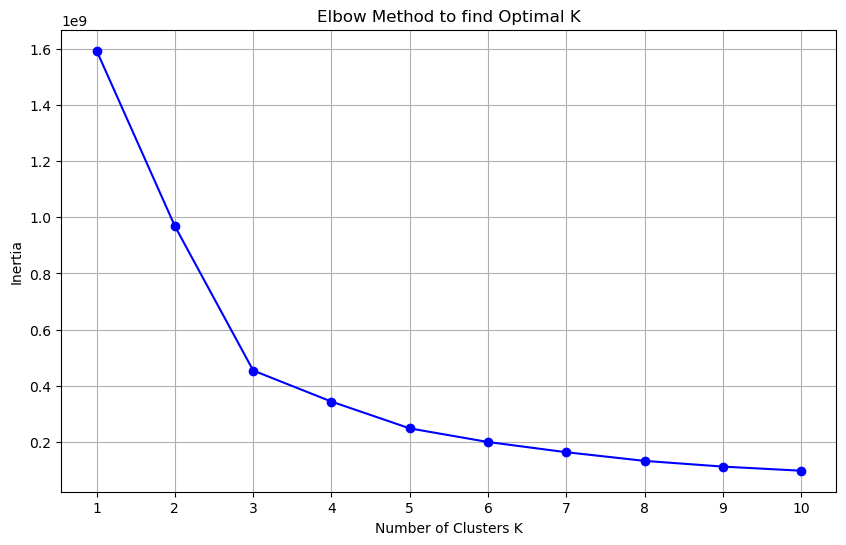

In [83]:
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters K')
plt.ylabel('Inertia')
plt.title('Elbow Method to find Optimal K')
plt.xticks(K)
plt.grid()
plt.show()

In [56]:

scaler = StandardScaler()
data_standardized = scaler.fit_transform(df)

# Step 2: Apply K-Means clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(data_standardized)

# Step 3: Get the cluster labels
df['cluster'] = kmeans.labels_
df.insert(0,'Player_name',df1["Player_name"])
# Optional: Display the results
df.head()



Player_name  Batting_avg  Batting_strikerate  Batting_total_runs  \
0       SC Ganguly    25.942308              106.81              1349.0   
1      BB McCullum    28.254902              131.60              2882.0   
2       RT Ponting    11.375000               71.09                91.0   
3        DJ Hussey    28.739130              122.98              1322.0   
4  Mohammad Hafeez     9.142857               77.11                64.0   

   Batting_boundary  Batting_dot  Bowling_balls  Bowling_over  Bowling_runs  \
0             59.30        47.43          276.0     46.000000         363.0   
1             67.73        43.20            0.0      0.000000           0.0   
2             35.16        53.12            0.0      0.000000           0.0   
3             54.46        37.12          317.0     52.833333         473.0   
4             62.50        60.24           60.0     10.000000          64.0   

   Bowling_economy  Bowling_wickets  Bowling_total_runs  Bowling_avg  \
0         7.891304             12.0               30.25         23.0   
1         0.000000              0.0                0.00          0.0   
2         0.000000              0.0                0.00          0.0   
3         8.952681             10.0               47.30         31.7   
4         6.400000              2.0               32.00         30.0   

   Bowling_strikerate  cluster  
0           14.130435        1  
1            0.000000        0  
2            0.000000        0  
3           17.350158        1  
4           11.666667        1

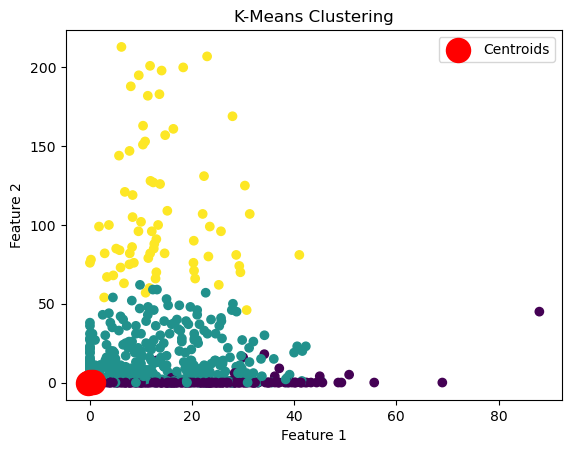

In [57]:


# Step 4: Visualize the clusters
plt.scatter(df['Batting_avg'], df['Bowling_wickets'], c=df['cluster'], cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


In [58]:
print(df)

         Player_name  Batting_avg  Batting_strikerate  Batting_total_runs  \
0         SC Ganguly    25.942308              106.81              1349.0   
1        BB McCullum    28.254902              131.60              2882.0   
2         RT Ponting    11.375000               71.09                91.0   
3          DJ Hussey    28.739130              122.98              1322.0   
4    Mohammad Hafeez     9.142857               77.11                64.0   
..               ...          ...                 ...                 ...   
727      M Siddharth     0.000000                0.00                 0.0   
728         MP Yadav     0.000000                0.00                 0.0   
729         S Joseph     0.000000                0.00                 0.0   
730       N Thushara     0.000000                0.00                 0.0   
731      V Kaverappa     0.000000                0.00                 0.0   

     Batting_boundary  Batting_dot  Bowling_balls  Bowling_over  Bowling_ru

In [60]:
print(df2[df2["Player_name"]=='V Kohli'])
print(df2[df2["Player_name"]=='JJ Bumrah']
print(df2[df2["Player_name"]=='JJ Bumrah']
print(df2[df2["Player_name"]=='R Sharma']

Player_name  Batting_avg  Batting_strikerate  Batting_total_runs  \
7     V Kohli    39.092683              132.05              8014.0   

   Batting_boundary  Batting_dot  Bowling_balls  Bowling_over  Bowling_runs  \
7             55.78        33.47          251.0     41.833333         367.0   

   Bowling_economy  Bowling_wickets  Bowling_total_runs  Bowling_avg  \
7         8.772908              5.0                73.4         50.2   

   Bowling_strikerate  cluster  
7           14.342629        1

In [61]:
df[df["Player_name"]=='JJ Bumrah']
df[df["Player_name"]=='JJ Bumrah']

Player_name  Batting_avg  Batting_strikerate  Batting_total_runs  \
375   JJ Bumrah    11.333333               87.18                68.0   

     Batting_boundary  Batting_dot  Bowling_balls  Bowling_over  Bowling_runs  \
375             38.24        44.87         3075.0         512.5        3723.0   

     Bowling_economy  Bowling_wickets  Bowling_total_runs  Bowling_avg  \
375          7.26439            182.0           20.456044    16.895604   

     Bowling_strikerate  cluster  
375           14.569106        2

In [63]:
df[df["Player_name"]=='R Sharma']

Player_name  Batting_avg  Batting_strikerate  Batting_total_runs  \
235    R Sharma          6.0                88.0                66.0   

     Batting_boundary  Batting_dot  Bowling_balls  Bowling_over  Bowling_runs  \
235             57.58        61.33          928.0    154.666667        1086.0   

     Bowling_economy  Bowling_wickets  Bowling_total_runs  Bowling_avg  \
235         7.021552             42.0           25.857143    22.095238   

     Bowling_strikerate  cluster  
235           12.392241        1

In [64]:
def positiongen(x):
    if(x==0):
        return("all rounder")
    elif(x==1):
        return("batsmen")
    else:
        return("bowler")

df["Player_position"] = df["cluster"].apply(positiongen)

In [71]:
print(df.iloc[:,[0,14]])

         Player_name  cluster
0         SC Ganguly        1
1        BB McCullum        0
2         RT Ponting        0
3          DJ Hussey        1
4    Mohammad Hafeez        1
..               ...      ...
727      M Siddharth        1
728         MP Yadav        1
729         S Joseph        1
730       N Thushara        1
731      V Kaverappa        1

[732 rows x 2 columns]


# cluster type 2

In [101]:
relevant_features = ['Batting_avg', 'Batting_strikerate', 'Batting_total_runs', 'Bowling_avg', 'Bowling_economy']
df2 = df
# Scaling the selected features
X_scaled = scaler.fit_transform(df2[relevant_features])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

KMeans(n_clusters=3, random_state=42)

In [104]:
df2['Cluster'] = kmeans.labels_

In [105]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Batting_avg         732 non-null    float64
 1   Batting_strikerate  732 non-null    float64
 2   Batting_total_runs  732 non-null    float64
 3   Batting_boundary    732 non-null    float64
 4   Batting_dot         732 non-null    float64
 5   Bowling_balls       732 non-null    float64
 6   Bowling_over        732 non-null    float64
 7   Bowling_runs        732 non-null    float64
 8   Bowling_economy     732 non-null    float64
 9   Bowling_wickets     732 non-null    float64
 10  Bowling_total_runs  732 non-null    float64
 11  Bowling_avg         732 non-null    float64
 12  Bowling_strikerate  732 non-null    float64
 13  Cluster             732 non-null    int32  
dtypes: float64(13), int32(1)
memory usage: 77.3 KB


In [106]:
df2.drop(columns=["Player_position"],inplace=True)

KeyError: "['Player_position'] not found in axis"

In [107]:
def positiongen(x):
    if(x==0):
        return("all rounder")
    elif(x==1):
        return("batsmen")
    else:
        return("bowler")

df2["Player_position"] = df2["Cluster"].apply(positiongen)

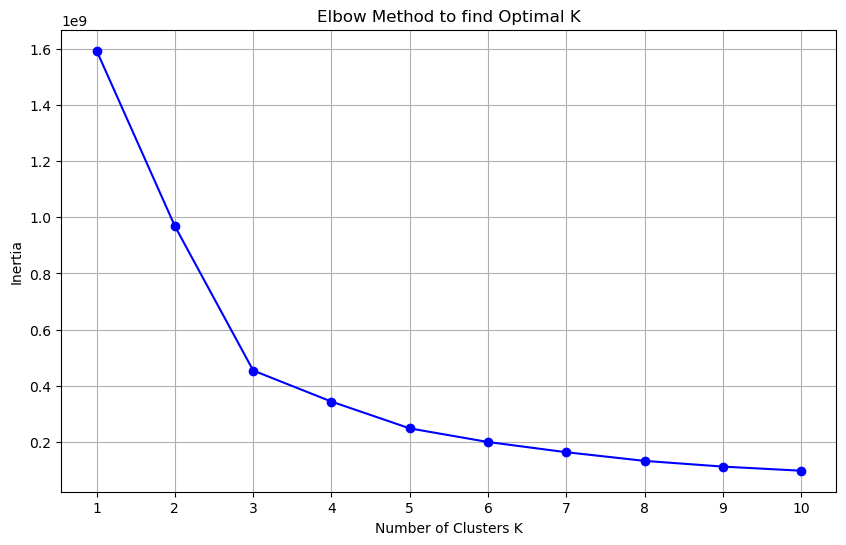

In [100]:
# inertia = []
# K = range(1, 11)

# for k in K:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(df2)
#     inertia.append(kmeans.inertia_)

# # Plotting the Elbow Method
# plt.figure(figsize=(10, 6))
# plt.plot(K, inertia, 'bo-')
# plt.xlabel('Number of Clusters K')
# plt.ylabel('Inertia')
# plt.title('Elbow Method to find Optimal K')
# plt.xticks(K)
# plt.grid()
# plt.show()

In [108]:
df2.head()

Batting_avg  Batting_strikerate  Batting_total_runs  Batting_boundary  \
0    25.942308              106.81              1349.0             59.30   
1    28.254902              131.60              2882.0             67.73   
2    11.375000               71.09                91.0             35.16   
3    28.739130              122.98              1322.0             54.46   
4     9.142857               77.11                64.0             62.50   

   Batting_dot  Bowling_balls  Bowling_over  Bowling_runs  Bowling_economy  \
0        47.43          276.0     46.000000         363.0         7.891304   
1        43.20            0.0      0.000000           0.0         0.000000   
2        53.12            0.0      0.000000           0.0         0.000000   
3        37.12          317.0     52.833333         473.0         8.952681   
4        60.24           60.0     10.000000          64.0         6.400000   

   Bowling_wickets  Bowling_total_runs  Bowling_avg  Bowling_strikerate  \
0             12.0               30.25         23.0           14.130435   
1              0.0                0.00          0.0            0.000000   
2              0.0                0.00          0.0            0.000000   
3             10.0               47.30         31.7           17.350158   
4              2.0               32.00         30.0           11.666667   

   Cluster Player_position  
0        1         batsmen  
1        0     all rounder  
2        0     all rounder  
3        1         batsmen  
4        2          bowler

# New Start

In [127]:
df_cleaned = df

In [129]:
df_cleaned.drop(columns=["Batting_boundary","Batting_dot","Bowling_balls","Bowling_economy","Bowling_total_runs","Bowling_strikerate","Bowling_avg"],inplace=True)

In [130]:
df_cleaned.head()

Player_name  Batting_avg  Batting_strikerate  Batting_total_runs  \
0       SC Ganguly    25.942308              106.81              1349.0   
1      BB McCullum    28.254902              131.60              2882.0   
2       RT Ponting    11.375000               71.09                91.0   
3        DJ Hussey    28.739130              122.98              1322.0   
4  Mohammad Hafeez     9.142857               77.11                64.0   

   Bowling_over  Bowling_runs  Bowling_wickets  Cluster Player_position  
0     46.000000         363.0             12.0        1         batsmen  
1      0.000000           0.0              0.0        0     all rounder  
2      0.000000           0.0              0.0        0     all rounder  
3     52.833333         473.0             10.0        1         batsmen  
4     10.000000          64.0              2.0        2          bowler

In [131]:
df_cleaned.drop(columns=["Player_name",'Cluster',"Player_position"],inplace=True)

In [132]:
df_cleaned

Batting_avg  Batting_strikerate  Batting_total_runs  Bowling_over  \
0      25.942308              106.81              1349.0     46.000000   
1      28.254902              131.60              2882.0      0.000000   
2      11.375000               71.09                91.0      0.000000   
3      28.739130              122.98              1322.0     52.833333   
4       9.142857               77.11                64.0     10.000000   
..           ...                 ...                 ...           ...   
727     0.000000                0.00                 0.0      9.166667   
728     0.000000                0.00                 0.0     12.166667   
729     0.000000                0.00                 0.0      4.000000   
730     0.000000                0.00                 0.0     26.000000   
731     0.000000                0.00                 0.0      4.000000   

     Bowling_runs  Bowling_wickets  
0           363.0             12.0  
1             0.0              0.0  
2             0.0              0.0  
3           473.0             10.0  
4            64.0              2.0  
..            ...              ...  
727          69.0              1.0  
728          85.0              8.0  
729          43.0              0.0  
730         255.0              8.0  
731          36.0              2.0  

[732 rows x 6 columns]

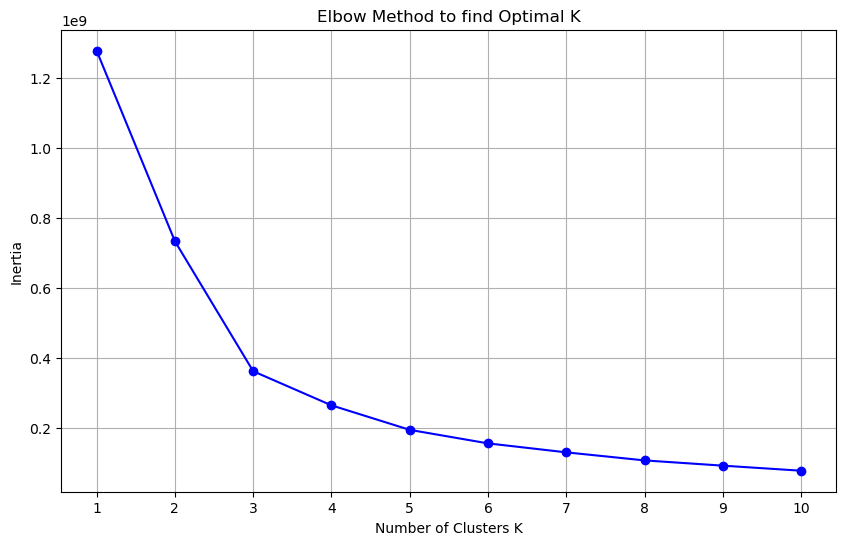

In [133]:
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_cleaned)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters K')
plt.ylabel('Inertia')
plt.title('Elbow Method to find Optimal K')
plt.xticks(K)
plt.grid()
plt.show()

In [134]:
X_Clean_scale = scaler.fit_transform(df_cleaned)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_Clean_scale)

KMeans(n_clusters=3, random_state=42)

In [135]:
df_cleaned['Cluster'] = kmeans.labels_

In [136]:
df_cleaned.head()

Batting_avg  Batting_strikerate  Batting_total_runs  Bowling_over  \
0    25.942308              106.81              1349.0     46.000000   
1    28.254902              131.60              2882.0      0.000000   
2    11.375000               71.09                91.0      0.000000   
3    28.739130              122.98              1322.0     52.833333   
4     9.142857               77.11                64.0     10.000000   

   Bowling_runs  Bowling_wickets  Cluster  
0         363.0             12.0        0  
1           0.0              0.0        0  
2           0.0              0.0        1  
3         473.0             10.0        0  
4          64.0              2.0        1

In [139]:
df_cleaned.insert(0,"Player_name",df1["Player_name"])

In [140]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Player_name         732 non-null    object 
 1   Batting_avg         732 non-null    float64
 2   Batting_strikerate  732 non-null    float64
 3   Batting_total_runs  732 non-null    float64
 4   Bowling_over        732 non-null    float64
 5   Bowling_runs        732 non-null    float64
 6   Bowling_wickets     732 non-null    float64
 7   Cluster             732 non-null    int32  
dtypes: float64(6), int32(1), object(1)
memory usage: 43.0+ KB


In [141]:
df_cleaned[df_cleaned["Player_name"]=="V Kohli"]

Player_name  Batting_avg  Batting_strikerate  Batting_total_runs  \
7     V Kohli    39.092683              132.05              8014.0   

   Bowling_over  Bowling_runs  Bowling_wickets  Cluster  
7     41.833333         367.0              5.0        0

In [142]:
df_cleaned[df_cleaned["Player_name"]=="RG Sharma"]

Player_name  Batting_avg  Batting_strikerate  Batting_total_runs  \
56   RG Sharma         30.0              131.11              6630.0   

    Bowling_over  Bowling_runs  Bowling_wickets  Cluster  
56          56.5         448.0             16.0        0

In [143]:
df_cleaned[df_cleaned["Player_name"]=="JJ Bumrah"]

Player_name  Batting_avg  Batting_strikerate  Batting_total_runs  \
375   JJ Bumrah    11.333333               87.18                68.0   

     Bowling_over  Bowling_runs  Bowling_wickets  Cluster  
375         512.5        3723.0            182.0        2

In [144]:
df_cleaned[df_cleaned["Player_name"]=="HH Pandya"]

Player_name  Batting_avg  Batting_strikerate  Batting_total_runs  \
400   HH Pandya    29.465116              145.72              2534.0   

     Bowling_over  Bowling_runs  Bowling_wickets  Cluster  
400    236.333333        2150.0             70.0        2

In [145]:
df_cleaned[df_cleaned["Player_name"]=="SR Watson"]

Player_name  Batting_avg  Batting_strikerate  Batting_total_runs  \
31   SR Watson    31.290323              137.93              3880.0   

    Bowling_over  Bowling_runs  Bowling_wickets  Cluster  
31    338.166667        2679.0            107.0        2

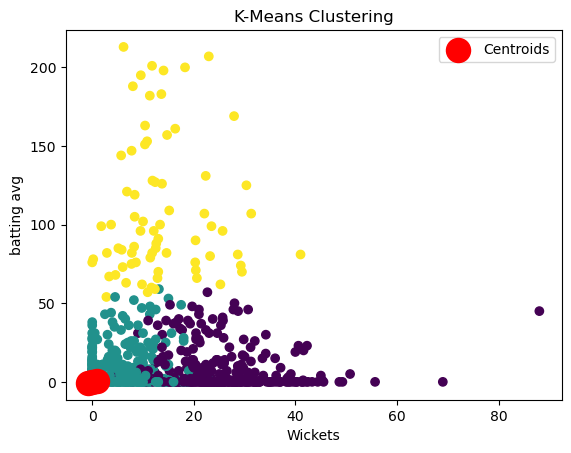

In [148]:
# Step 4: Visualize the clusters
plt.scatter(df_cleaned['Batting_avg'], df_cleaned['Bowling_wickets'], c=df['Cluster'], cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')
plt.title('K-Means Clustering')
plt.xlabel('Wickets')
plt.ylabel('batting avg')
plt.legend()
plt.show()


### Bowler Cluster

In [4]:
data = pd.read_csv("players_stats.csv")

In [10]:
bowlingdata = data[["Bowling_over","Bowling_runs","Bowling_wickets"]]
bowlingdata.fillna(0,inplace =True)
bowlingdata

Bowling_over  Bowling_runs  Bowling_wickets
0       46.000000         363.0             12.0
1        0.000000           0.0              0.0
2        0.000000           0.0              0.0
3       52.833333         473.0             10.0
4       10.000000          64.0              2.0
..            ...           ...              ...
727      9.166667          69.0              1.0
728     12.166667          85.0              8.0
729      4.000000          43.0              0.0
730     26.000000         255.0              8.0
731      4.000000          36.0              2.0

[732 rows x 3 columns]

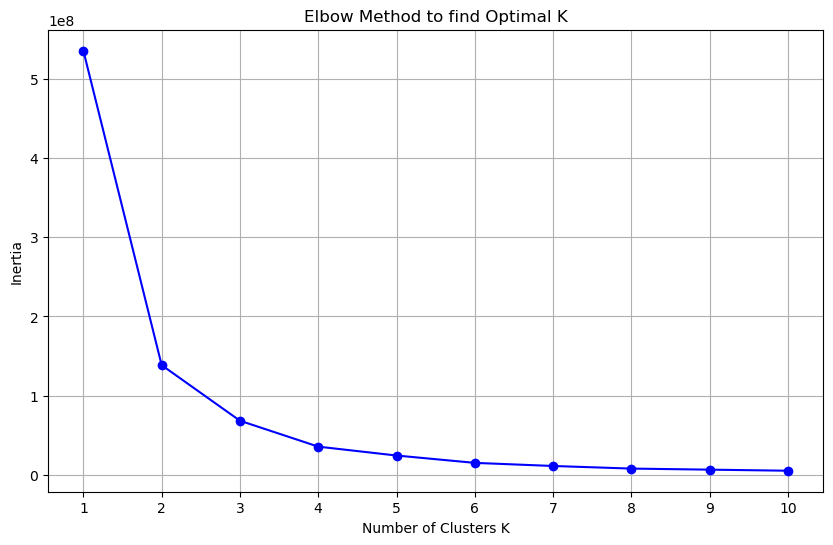

In [11]:
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(bowlingdata)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters K')
plt.ylabel('Inertia')
plt.title('Elbow Method to find Optimal K')
plt.xticks(K)
plt.grid()
plt.show()

In [13]:
scaler = StandardScaler()
bowling_scaled = scaler.fit_transform(bowlingdata)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(bowling_scaled)

KMeans(n_clusters=3, random_state=42)

In [15]:
bowlingdata['Cluster'] = kmeans.labels_
bowlingdata.insert(0,"Player_name",data["Player_name"])

In [16]:
bowlingdata.head()

Player_name  Bowling_over  Bowling_runs  Bowling_wickets  Cluster
0       SC Ganguly     46.000000         363.0             12.0        0
1      BB McCullum      0.000000           0.0              0.0        0
2       RT Ponting      0.000000           0.0              0.0        0
3        DJ Hussey     52.833333         473.0             10.0        0
4  Mohammad Hafeez     10.000000          64.0              2.0        0

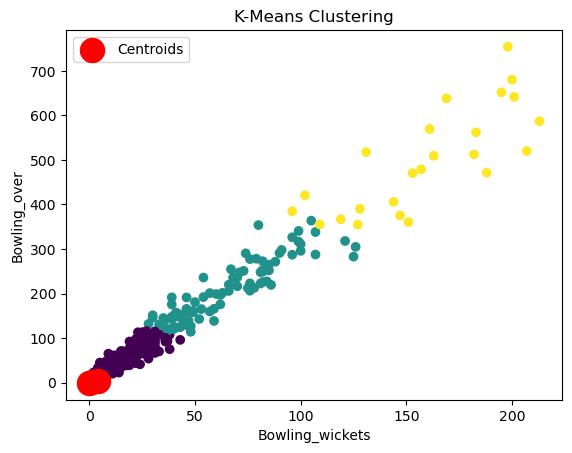

In [18]:
plt.scatter(bowlingdata['Bowling_wickets'], bowlingdata['Bowling_over'], c=bowlingdata['Cluster'], cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')
plt.title('K-Means Clustering')
plt.xlabel('Bowling_wickets')
plt.ylabel('Bowling_over')
plt.legend()
plt.show()

In [19]:
bowlingdata[bowlingdata["Player_name"]=="V Kohli"]

Player_name  Bowling_over  Bowling_runs  Bowling_wickets  Cluster
7     V Kohli     41.833333         367.0              5.0        0

In [20]:
bowlingdata[bowlingdata["Player_name"]=="RG Sharma"]

Player_name  Bowling_over  Bowling_runs  Bowling_wickets  Cluster
56   RG Sharma          56.5         448.0             16.0        0

In [21]:
bowlingdata[bowlingdata["Player_name"]=="JJ Bumrah"]

Player_name  Bowling_over  Bowling_runs  Bowling_wickets  Cluster
375   JJ Bumrah         512.5        3723.0            182.0        2

In [23]:
bowlingdata[bowlingdata["Player_name"]=="HH Pandya"]

Player_name  Bowling_over  Bowling_runs  Bowling_wickets  Cluster
400   HH Pandya    236.333333        2150.0             70.0        1

In [24]:
bowlingdata[bowlingdata["Player_name"]=="SR Watson"]

Player_name  Bowling_over  Bowling_runs  Bowling_wickets  Cluster
31   SR Watson    338.166667        2679.0            107.0        1

In [26]:
bowlingdata[bowlingdata["Player_name"]=="AR Patel"]

Player_name  Bowling_over  Bowling_runs  Bowling_wickets  Cluster
374    AR Patel         517.5        3754.0            131.0        2

In [29]:
bowlingdata["Cluster"].value_counts()

Cluster
0    620
1     88
2     24
Name: count, dtype: int64